<a href="https://colab.research.google.com/github/DS3001/group9/blob/main/midterm_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! git clone https://github.com/DS3001/group9

Cloning into 'group9'...
fatal: could not read Username for 'https://github.com': No such device or address


# Import dependencies and load data

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import zipfile # for reading csv as zip

In [6]:
# zip file in git repo
zip_path = "/gss.csv.zip"

# Desired csv file in zip
file_to_read = "gss.csv"

with zipfile.ZipFile(zip_path, 'r') as zip_file:

  var_list = ['pres80', 'degree', 'age', 'race', 'sex', 'rincom82', 'rincom86'] # List of variables to save
  output_file = 'raw_gss_data.csv' # Name of the file to save the data to

  parser = pd.read_csv(zip_file.open(file_to_read), iterator=True, chunksize=10000, low_memory=False) # Creates a parser for the whole data
  modes = ['w','a'] # Has write mode and append mode
  phase = 0 # Starts in write mode; after one iteration of loop, switches to append mode

  for chunk in parser: # For each chunk of the data
      print(chunk.loc[:,var_list].head()) # Visually inspect the first few rows
      chunk.loc[:,var_list].to_csv(output_file, # specifies target file to save the chunk to
                                  mode=modes[phase], # control write versus append
                                  header=var_list, # variable names
                                  index=False) # no row index saved
      phase = 1 # Switch from write mode to append mode




   pres80                 degree   age   race     sex  rincom82  rincom86
0     NaN             bachelor's  23.0  white  female       NaN       NaN
1     NaN  less than high school  70.0  white    male       NaN       NaN
2     NaN            high school  48.0  white  female       NaN       NaN
3     NaN             bachelor's  27.0  white  female       NaN       NaN
4     NaN            high school  61.0  white  female       NaN       NaN
      pres80                 degree   age   race     sex rincom82 rincom86
10000    NaN            high school  28.0  black  female      NaN      NaN
10001    NaN            high school  20.0  white  female      NaN      NaN
10002    NaN            high school  57.0  white    male      NaN      NaN
10003    NaN            high school  20.0  white  female      NaN      NaN
10004    NaN  less than high school  19.0  other    male      NaN      NaN
      pres80                 degree   age   race     sex  rincom82  \
20000    NaN  less than high school 

In [21]:
# Create dataframe from 'raw_gss_data.csv' that was just written
gss_dat = pd.read_csv("raw_gss_data.csv")


# Data cleaning and preprocessing

In [ ]:
gss_dat['pres80'].unique()

array([nan, 'pres80', 'reagan', 'carter', 'anderson', 'refused_(5)',
       'other', 'didnt vote'], dtype=object)

In [22]:
#print(gss_dat['pres80'].value_counts())

# Remove "didn't vote for president" and other no answer responses (see codebook), also deleted Anderson as we want binary prediction variable
gss_dat = gss_dat.loc[
    (gss_dat['pres80'] == 'reagan') |
    (gss_dat['pres80'] == 'carter'), :]

# Every entry either voted for Trump, Clinton, or other unspecified candidate
print(gss_dat['pres80'].value_counts())
print(gss_dat['pres80'].isnull().sum())


# data is now filtered for years 82-87, as observations for pres80 are only in this range

carter    2635
reagan    2218
Name: pres80, dtype: int64
0


<Axes: >

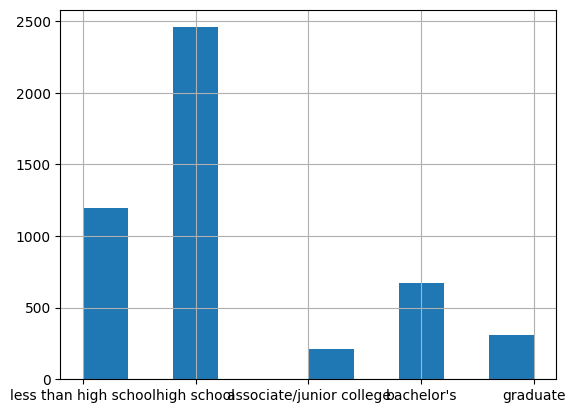

In [23]:
# Used to restore original 'degree' bc I keep messing it up
gss_dat['degree'].isnull().sum()
gss_dat['degree'].value_counts()
gss_dat['degree'].unique() # NaN and 'degree' present

gss_dat = gss_dat.loc[(~gss_dat['degree'].isnull()) & (gss_dat['degree'] != 'degree'), ] # keep rows where value for degree is not NaN or 'degree' (see codebook, NaN and 'degree' respones are invalid)
gss_dat['degree'].unique() # all observations are now "bachelor's", 'less than high school', 'high school', 'graduate', or 'associate/junior college'

gss_dat['degree'].hist()

In [24]:
# rincom82
# because of the distribution of this histogram, I think it is ok to take the mean of each range as its numeric value
## $50,000 + is ok as 50000 as it is not a huge proportion of the data
#gss_dat['rincom82'].hist()
gss_dat['rincom82'].unique()

gss_dat['rincom82'].value_counts()
# recode all values to numeric mean of range
temp = gss_dat['rincom82'].replace('lt $1000', 1000).replace('$1000-2999', 2000).replace('$3000-3999', 3500).replace('$4000-4999', 4500).replace('$5000-5999', 5500).replace('$6000-6999', 6500).replace('$7000-7999', 7500).replace('$8000-9999', 9000).replace('$10000-12499', 11250).replace('$12500-14999', 13750).replace('$15000-17499', 16250).replace('$17500-19999', 18750).replace('$20000-22499', 21250).replace('$22500-24999', 23750).replace('$25000-34999', 30000).replace('$35000-49999', 42500).replace('$50000 +', 50000)
temp.value_counts()
gss_dat['rincom82'] = temp



# rincom86
gss_dat['rincom86'].value_counts()
# recode all values to numeric mean of range
temp = gss_dat['rincom86'].replace('lt $1000', 1000).replace('$1000-2999', 2000).replace('$3000-3999', 3500).replace('$4000-4999', 4500).replace('$5000-5999', 5500).replace('$6000-6999', 6500).replace('$7000-7999', 7500).replace('$8000-9999', 9000).replace('$10000-12499', 11250).replace('$12500-14999', 13750).replace('$15000-17499', 16250).replace('$17500-19999', 18750).replace('$20000-22499', 21250).replace('$22500-24999', 23750).replace('$25000-29999', 27500).replace('$30000-34999', 32500).replace('$35000-39999', 37500).replace('$40000-49999', 45000).replace('$50000-59999', 55000).replace('$60000+', 60000)
temp.value_counts()
gss_dat['rincom86'] = temp

gss_dat = gss_dat.loc[(~gss_dat['rincom82'].isnull()) |
                      (~gss_dat['rincom86'].isnull()), ] # dropped all rows where rincom82 is a NaN or rincom86 is a NaN


print(gss_dat['rincom82'].unique())
print(gss_dat['rincom86'].unique())

# Combine data
gss_dat['income'] = gss_dat['rincom82'].fillna(gss_dat['rincom86']) # make a combined column 'income' that is equal to rincom82 unless it is NaN, then equal to rincom86
gss_dat['income'].describe()



[18750. 16250. 11250.  2000. 30000.  1000.  6500.  4500.  3500. 21250.
 23750.  7500. 13750.  5500. 50000.  9000. 42500.    nan]
[   nan 60000. 11250. 27500. 21250. 23750. 32500.  7500.  5500.  3500.
  1000. 55000.  4500. 37500. 13750. 16250.  2000.  9000. 18750. 45000.
  6500.]


<ipython-input-24-121a454802f7>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gss_dat['income'] = gss_dat['rincom82'].fillna(gss_dat['rincom86']) # make a combined column 'income' that is equal to rincom82 unless it is NaN, then equal to rincom86


count     3033.000000
mean     18614.820310
std      13497.678283
min       1000.000000
25%       9000.000000
50%      16250.000000
75%      27500.000000
max      60000.000000
Name: income, dtype: float64



**Data preprocessing for kNN**

In [26]:
# Coerce age to numeric
print(gss_dat['age'].value_counts())
gss_dat['age'].isnull().sum()
gss_dat = gss_dat.loc[~gss_dat['age'].isnull(), ] # keep rows where age is NOT null
gss_dat['age'].isnull().sum()

gss_dat['age'] = pd.to_numeric(gss_dat['age'], errors="coerce")

35.0    100
37.0     97
34.0     94
30.0     90
28.0     88
       ... 
20.0      2
81.0      2
80.0      2
79.0      1
84.0      1
Name: age, Length: 65, dtype: int64


In [27]:
gss_dat['degree'] = gss_dat['degree'].replace('less than high school', 0).replace('high school', 1).replace('associate/junior college', 2).replace("bachelor's", 3).replace('graduate', 4)
# 0 = Less than hs
# 1 = hs
# 2 = associate/junior college
# 3 = bachelors
# 4 = graduate


In [28]:
gss_dat['pres80'] = gss_dat['pres80'].replace('reagan', 0).replace('carter', 1)

In [29]:
# Function to max-min normalize data so each variables ranges from 0-1
def maxmin(x):
  res = (x-min(x))/(max(x)-min(x))
  return res




**Model fitting**

In [51]:
from sklearn.model_selection import train_test_split

# Maxmin normalize data and split into training/testing sets
X = gss_dat[['income', 'age']]
y = gss_dat['pres80']

X = X.apply(maxmin)
print(X.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=74)
print("X_train data:", X_train.shape)
print("X_test data:", X_test.shape)
print("y_train data:", y_train.shape)
print("y_test data:", y_test.shape)

print(X_train.columns)
print(X_test.columns)

         income       age
12121  0.300847  0.328125
12129  0.258475  0.531250
12132  0.173729  0.156250
12133  0.016949  0.515625
12134  0.300847  0.296875
X_train data: (2424, 2)
X_test data: (607, 2)
y_train data: (2424,)
y_test data: (607,)
Index(['income', 'age'], dtype='object')
Index(['income', 'age'], dtype='object')


In [73]:
# Fit model
from sklearn.neighbors import KNeighborsRegressor as kNNRegressor

knn_model = kNNRegressor(n_neighbors=63)
fitted_model = knn_model.fit(X_train, y_train)


In [78]:
# Run regression model
# Regression function for Age and AnnualSalary
def plot_regression(X_train, y_train):

  N_x = 100
  N_y = 100 # Coarseness of y variable
  total = N_x*N_y # Total number of points to plot

  grid_x = np.linspace(0,1,N_x) # Create a grid of x values
  grid_y = np.linspace(0,1,N_y) # Create a grid of y values

  xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
  X = xs.reshape(total) # Turns pairs into vectors
  Y = ys.reshape(total) # Turns pairs into vectors

  x_hat = pd.DataFrame({'income':X,'age':Y}) # Create a dataframe of points to plot
  y_hat = fitted_model.predict(x_hat) # Fit the model to the points
  x_hat['Predicted'] = y_hat # Add new variable to the dataframe

  # Red to blue palette to show traditional political colors
  red_to_blue_palette = sns.color_palette("RdBu_r", n_colors=36) # n_colors determined by k

  this_plot = sns.scatterplot(data=x_hat,x='age',y='income',hue='Predicted', palette= red_to_blue_palette) # Create seaborn plot
  sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

  return x_hat

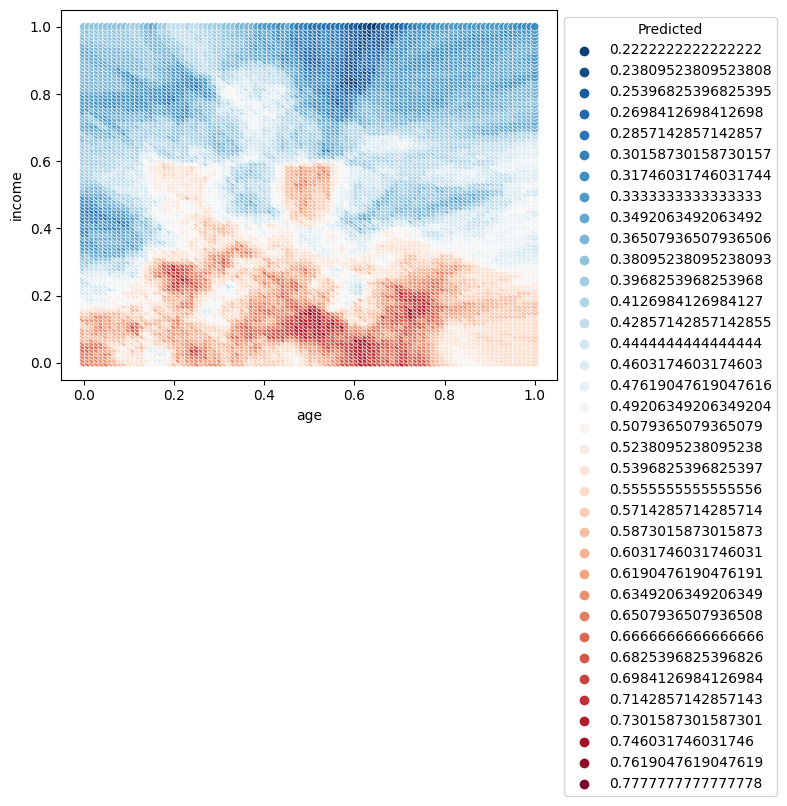

In [79]:
train_dat = plot_regression(X_train, y_train)

In [70]:
# Determine k value
# Determine optimal k val for this data

k_bar = 70
k_grid = np.arange(1,k_bar)
SSE_train = np.zeros(k_bar)
SSE_test = np.zeros(k_bar)
for k in range(k_bar):
    model = kNNRegressor(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test) # Predict values for test set
    SSE_test[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
    y_hat = fitted_model.predict(X_train) # Predict values for training set
    SSE_train[k] = np.sum( (y_train-y_hat)**2 ) # Save the computed SSE

SSE_min = np.min(SSE_test) # Lowest recorded SSE
min_index = np.where(SSE_test==SSE_min) # Find the indices of y that equal the minimum
k_star = k_grid[min_index] # Find the optimal value of k
print(k_star)

[63]


Text(0, 0.5, 'SSE')

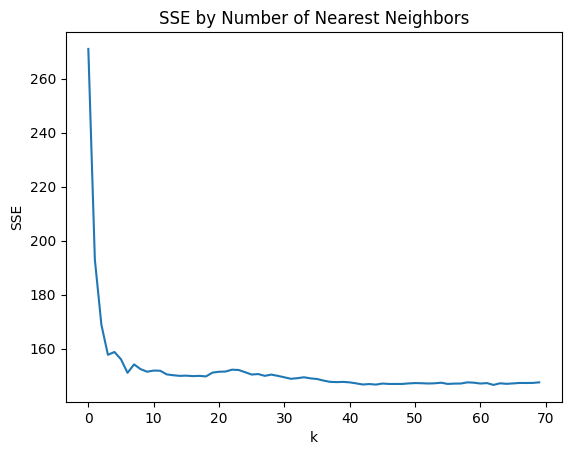

In [80]:
plt.title("SSE by Number of Nearest Neighbors")
plt.plot(np.arange(0,k_bar),SSE_test,label='Test') # Plot SSE by k
plt.xlabel("k")
plt.ylabel("SSE")

In [ ]:
# Carter scatter
plot = sns.scatterplot(gss_dat.loc[gss_dat['pres80'] == 'carter'], x='income', y='age', hue='pres80')
plot.set_yticks([20, 30, 40, 50, 60, 70, 80, 90])

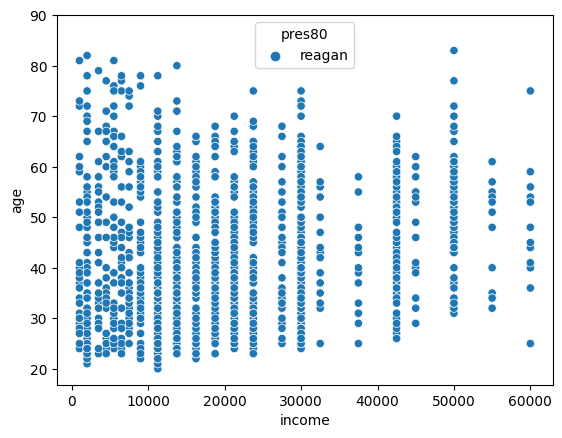

In [ ]:
# Reagan scatter
plot = sns.scatterplot(gss_dat.loc[gss_dat['pres80'] == 'reagan'], x='income', y='age', hue='pres80')
plot.set_yticks([20, 30, 40, 50, 60, 70, 80, 90])

In [ ]:
### to-do ideas ###
#   - K means clustering on each separate group, compare clusters
#   - look further based on sex and/or race breakdown
#

In [ ]:
pd.crosstab(gss_dat['race'], gss_dat['pres80'])

pres80,anderson,carter,reagan
race,,,
black,12,504,20
other,1,36,18
white,229,1091,1362


In [ ]:
# numbers are close, no distinct splits
pd.crosstab(gss_dat['sex'], gss_dat['pres80'])

pres80,anderson,carter,reagan
sex,,,
female,126,881,619
male,116,750,781


In [ ]:
### ignore below ###

In [ ]:
gss_dat['abmoral'].value_counts() # clean, can remove "depends" for more specific results
gss_dat['abmoral'].isnull().sum() # so many absent values, no reason to continue with variable
gss_dat.drop('abmoral', axis=1, inplace=True) # drop column 'abmoral' on axis 1 (column)

In [ ]:
gss_dat['madeg'].isnull().sum()
gss_dat['madeg'].unique() # NaNs present

gss_dat = gss_dat.loc[~gss_dat['madeg'].isnull(), ] # keep rows where value for madeg is not NaN
gss_dat['madeg'].unique() # NaNs present

array(['high school', 'less than high school', "bachelor's", 'graduate',
       'associate/junior college'], dtype=object)

In [ ]:
gss_dat['padeg'].isnull().sum()
gss_dat['padeg'].unique() # NaNs present

gss_dat = gss_dat.loc[~gss_dat['padeg'].isnull(), ] # keep rows where value for padeg is not NaN
gss_dat['padeg'].unique() # NaNs present

array(['high school', 'less than high school', 'associate/junior college',
       "bachelor's", 'graduate'], dtype=object)

In [ ]:
gss_dat['sex'].unique() # NaN present
gss_dat = gss_dat.loc[~gss_dat['sex'].isnull(), ] # check codebook, sex == nan does not make sense in context of survey
gss_dat['sex'].unique()

array(['male', 'female'], dtype=object)

Proportion white: 0.8429476492164054
Proportion black: 0.09736578859619874
Proportion other than w/b: 0.0596865621873958


<Axes: >

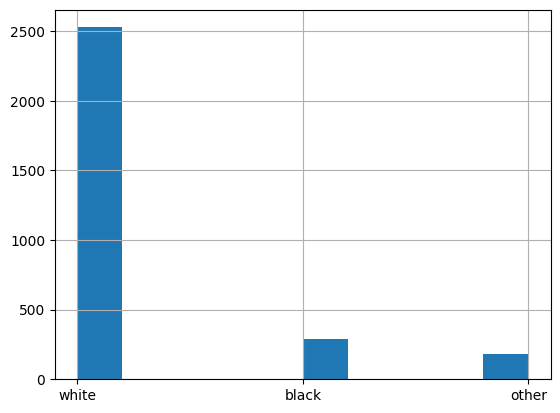

In [ ]:
gss_dat['race'].value_counts().sum()
gss_dat = gss_dat.loc[~gss_dat['race'].isnull(), ] # keep rows where race is not null

gss_dat['race'].unique()
print("Proportion white:", (gss_dat['race'] == 'white').sum() / (len(gss_dat))) # output of proportions of race in data for reference/Data write up
print("Proportion black:", (gss_dat['race'] == 'black').sum() / (len(gss_dat)))
print("Proportion other than w/b:", (gss_dat['race'] == 'other').sum() / (len(gss_dat)))

gss_dat['race'].hist()

In [ ]:
gss_dat = gss_dat.loc[(~gss_dat['wrkstat'].isnull()), ] # remove NaNs
gss_dat['wrkstat'] = gss_dat['wrkstat'].replace('unemployed, laid off, looking for work', 'unemployed') # replace long string of unemployed states with 'unemployed'
(gss_dat['wrkstat'] == 'with a job, but not at work because of temporary illness, vacation, strike').sum() # relatively few entries, annoying value

gss_dat = gss_dat.loc[gss_dat['wrkstat'] != 'with a job, but not at work because of temporary illness, vacation, strike', ] # delete rows w/ this entry ^
print(gss_dat['wrkstat'].value_counts())

working full time    1389
retired               868
working part time     274
keeping house         180
unemployed            112
other                  58
in school              44
Name: wrkstat, dtype: int64


<ipython-input-16-c810d216cb43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gss_dat['wrkstat'] = gss_dat['wrkstat'].replace('unemployed, laid off, looking for work', 'unemployed') # replace long string of unemployed states with 'unemployed'


In [ ]:
gss_dat = gss_dat.loc[~gss_dat['wrkstat'].isnull(), ]
gss_dat['wrkgovt'].unique()

array(['private', 'government', nan], dtype=object)

In [ ]:
# Shows that many mothers and fathers have similiar levels of education
pd.crosstab(gss_dat['madeg'], gss_dat['padeg'])

padeg,associate/junior college,bachelor's,graduate,high school,less than high school
madeg,,,,,
associate/junior college,23,29,16,77,17
bachelor's,11,159,129,113,16
graduate,6,46,91,41,7
high school,49,193,101,971,281
less than high school,8,13,6,139,383
